In [5]:
import numpy as np
import librosa
import soundfile as sf
import pywt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


def load_audio(file_path, target_sr=44100, mono=False):
    """
    Load an audio file and resample to target sample rate.

    Parameters:
    - file_path: Path to the audio file.
    - target_sr: Target sample rate in Hz.
    - mono: Whether to convert the audio to mono.

    Returns:
    - audio: Numpy array of audio samples.
             Shape: (channels, samples) if stereo, (samples,) if mono.
    - sr: Sample rate of the loaded audio.
    """
    audio, sr = librosa.load(file_path, sr=target_sr, mono=mono)
    if not mono:
        # librosa returns shape (channels, samples) when mono=False
        # Transpose to (channels, samples) if necessary
        if audio.ndim == 1:
            audio = np.expand_dims(audio, axis=0)
    return audio, sr


def save_audio(file_path, audio, sr, subtype='PCM_16'):
    """
    Save an audio array to a file with specified bit depth.

    Parameters:
    - file_path: Path where the audio will be saved.
    - audio: Numpy array of audio samples.
             Shape: (channels, samples) if stereo, (samples,) if mono.
    - sr: Sample rate in Hz.
    - subtype: Bit depth format (e.g., 'PCM_16', 'PCM_24', 'PCM_32').

    Note:
    - soundfile expects audio in shape (samples, channels) for multi-channel audio.
    """
    if audio.ndim > 1:
        # Transpose to (samples, channels)
        audio = audio.T
    sf.write(file_path, audio, sr, subtype=subtype)


def embed_dwt(cover, secret, wavelet='haar', level=1, alpha=0.1):
    """
    Embed secret audio into cover audio using DWT.

    Parameters:
    - cover: Numpy array of cover audio samples.
             Shape: (channels, samples) if stereo, (samples,) if mono.
    - secret: Numpy array of secret audio samples.
              Shape: (channels, samples) if stereo, (samples,) if mono.
    - wavelet: Wavelet type for DWT.
    - level: Decomposition level.
    - alpha: Embedding strength factor.

    Returns:
    - stego: Numpy array of stego-audio samples.
             Shape: same as cover.
    """
    if cover.ndim == 1:
        channels = 1
        cover = np.expand_dims(cover, axis=0)
        secret = np.expand_dims(secret, axis=0)
    else:
        channels = cover.shape[0]

    stego = np.copy(cover)

    for ch in range(channels):
        # Perform DWT on cover and secret
        coeffs_cover = pywt.wavedec(cover[ch], wavelet, level=level)
        coeffs_secret = pywt.wavedec(secret[ch], wavelet, level=level)

        # Embed secret coefficients into cover coefficients
        # Typically, embed in higher frequency sub-bands for better imperceptibility
        # Here, we choose to embed in detail coefficients (cD)
        # coeffs = [cA, cD1, cD2, ..., cDn]
        stego_coeffs = [coeffs_cover[0]]  # Keep approximation coefficients unchanged
        for i in range(1, len(coeffs_cover)):
            stego_coeffs.append(coeffs_cover[i] + alpha * coeffs_secret[i])

        # Perform inverse DWT to get stego channel
        stego_channel = pywt.waverec(stego_coeffs, wavelet)
        # Ensure stego channel length matches original
        stego_channel = stego_channel[:len(cover[ch])]
        # Normalize to prevent clipping
        stego[ch] = np.clip(stego_channel, -1.0, 1.0)

    if channels == 1:
        stego = stego.flatten()

    return stego


def extract_dwt(stego, cover, wavelet='haar', level=1, alpha=0.1):
    """
    Extract secret audio from stego audio using DWT.

    Parameters:
    - stego: Numpy array of stego-audio samples.
             Shape: (channels, samples) if stereo, (samples,) if mono.
    - cover: Numpy array of original cover audio samples.
             Shape: (channels, samples) if stereo, (samples,) if mono.
    - wavelet: Wavelet type for DWT.
    - level: Decomposition level.
    - alpha: Embedding strength factor used during embedding.

    Returns:
    - secret_extracted: Numpy array of extracted secret audio samples.
                        Shape: same as cover.
    """
    if stego.ndim == 1:
        channels = 1
        stego = np.expand_dims(stego, axis=0)
        cover = np.expand_dims(cover, axis=0)
    else:
        channels = stego.shape[0]

    secret_extracted = np.copy(cover)

    for ch in range(channels):
        # Perform DWT on stego and cover
        coeffs_stego = pywt.wavedec(stego[ch], wavelet, level=level)
        coeffs_cover = pywt.wavedec(cover[ch], wavelet, level=level)

        # Extract secret coefficients
        # coeffs = [cA, cD1, cD2, ..., cDn]
        coeffs_secret = [coeffs_stego[0]]  # Approximation coefficients are not used for embedding
        for i in range(1, len(coeffs_stego)):
            coeffs_secret.append((coeffs_stego[i] - coeffs_cover[i]) / alpha)

        # Perform inverse DWT to get secret channel
        secret_channel = pywt.waverec(coeffs_secret, wavelet)
        # Ensure secret channel length matches original
        secret_channel = secret_channel[:len(cover[ch])]
        # Normalize to prevent clipping
        secret_extracted[ch] = np.clip(secret_channel, -1.0, 1.0)

    if channels == 1:
        secret_extracted = secret_extracted.flatten()

    return secret_extracted


def calculate_metrics(original, modified):
    """
    Calculate MSE and SNR between original and modified signals.

    Parameters:
    - original: Numpy array of original audio samples.
    - modified: Numpy array of modified audio samples.

    Returns:
    - mse: Mean Squared Error.
    - snr: Signal-to-Noise Ratio in dB.
    """
    if len(original) != len(modified):
        raise ValueError(f"Original and modified signals must have the same length. "
                         f"Got {len(original)} and {len(modified)}.")

    mse = mean_squared_error(original, modified)
    # To calculate SNR, prevent division by zero
    signal_power = np.mean(original ** 2)
    if mse == 0:
        snr = float('inf')
    else:
        snr = 10 * np.log10(signal_power / mse)
    return mse, snr


def plot_waveforms(original, modified, title1='Original', title2='Modified'):
    """
    Plot two waveforms for comparison.

    Parameters:
    - original: Numpy array of original audio samples.
    - modified: Numpy array of modified audio samples.
    - title1: Title for the first plot.
    - title2: Title for the second plot.
    """
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(original)
    plt.title(title1)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(1, 2, 2)
    plt.plot(modified)
    plt.title(title2)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()


def plot_spectrogram(audio, sr, title='Spectrogram'):
    """
    Plot the spectrogram of an audio signal.

    Parameters:
    - audio: Numpy array of audio samples.
    - sr: Sample rate of the audio.
    - title: Title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.specgram(audio, Fs=sr, NFFT=2048, noverlap=1024, cmap='viridis')
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()


def calculate_rms(audio):
    """
    Calculate the Root Mean Square (RMS) of the audio signal.

    Parameters:
    - audio: Numpy array of audio samples.

    Returns:
    - rms: RMS value of the audio.
    """
    return np.sqrt(np.mean(audio ** 2))


def plot_rms(cover, stego, secret_extracted):
    """
    Plot the RMS energy comparison of cover, stego, and extracted secret audio.

    Parameters:
    - cover: Numpy array of cover audio samples.
    - stego: Numpy array of stego audio samples.
    - secret_extracted: Numpy array of extracted secret audio samples.
    """
    rms_cover = calculate_rms(cover.flatten())
    rms_stego = calculate_rms(stego.flatten())
    rms_extracted = calculate_rms(secret_extracted.flatten())

    labels = ['Cover Audio', 'Stego Audio', 'Extracted Secret']
    rms_values = [rms_cover, rms_stego, rms_extracted]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, rms_values, color=['blue', 'orange', 'green'])
    plt.title('RMS Energy Comparison')
    plt.ylabel('RMS Value')
    plt.show()


def overlay_waveforms(cover, stego):
    """
    Overlay the waveforms of cover and stego audio for comparison.

    Parameters:
    - cover: Numpy array of cover audio samples.
    - stego: Numpy array of stego audio samples.
    """
    plt.figure(figsize=(14, 5))
    plt.plot(cover.flatten(), label='Cover Audio', alpha=0.6)
    plt.plot(stego.flatten(), label='Stego Audio', alpha=0.6)
    plt.title('Waveform Overlay: Cover vs Stego Audio')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


def plot_histogram(audio, title='Amplitude Histogram'):
    """
    Plot the histogram of the audio amplitude values.

    Parameters:
    - audio: Numpy array of audio samples.
    - title: Title for the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(audio.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.xlim([-1, 1])
    plt.show()


def plot_correlation(original, modified):
    """
    Plot the correlation between two audio signals.

    Parameters:
    - original: Numpy array of original audio samples.
    - modified: Numpy array of modified audio samples.
    """
    if len(original) != len(modified):
        raise ValueError(f"Original and modified signals must have the same length for correlation plot. "
                         f"Got {len(original)} and {len(modified)}.")

    correlation = np.corrcoef(original.flatten(), modified.flatten())[0, 1]

    plt.figure(figsize=(8, 5))
    plt.scatter(original.flatten(), modified.flatten(), alpha=0.5, s=1)
    plt.title(f'Cover vs Stego Correlation (r={correlation:.2f})')
    plt.xlabel('Cover Audio Amplitude')
    plt.ylabel('Stego Audio Amplitude')
    plt.axline((0, 0), slope=1, color='red', linestyle='--')
    plt.grid()
    plt.show()

In [6]:
def main():
    # === Configuration ===
    TARGET_SAMPLE_RATE = 44100  # Can change this as needed
    WAVELET = 'haar'            # Wavelet type for DWT
    LEVEL = 1                   # Decomposition level
    ALPHA = 0.1                 # Embedding strength factor

    # File paths
    cover_file = r'E:\Major_Project\Audio\DWT\Data\Baby laughing sound funny video on copyright.wav'  # Replace with cover audio file path
    secret_file = r'E:\Major_Project\Audio\DWT\Data\TIGER ROAR SOUND IN HIGH QUALITY.wav'                # Replace with secret audio file path
    stego_file = 'stego_audio.wav'
    extracted_secret_file = 'extracted_secret.wav'

    # === Load Audio Files ===
    print("Loading audio files...")
    cover, sr_cover = load_audio(cover_file, target_sr=TARGET_SAMPLE_RATE, mono=False)
    secret, sr_secret = load_audio(secret_file, target_sr=TARGET_SAMPLE_RATE, mono=False)

    # === Debugging: Check Dimensions ===
    print(f"Cover audio shape: {cover.shape}")
    print(f"Secret audio shape: {secret.shape}")

    # === Ensure Both Audios Have the Same Number of Channels ===
    if cover.ndim > 1 and secret.ndim > 1:
        cover_channels = cover.shape[0]
        secret_channels = secret.shape[0]
        if cover_channels != secret_channels:
            print("Adjusting number of channels to match cover and secret audio...")
            if cover_channels > secret_channels:
                # Pad secret with zeros to match cover's channels
                pad_width = ((0, cover_channels - secret_channels), (0, 0))
                secret = np.pad(secret, pad_width, 'constant')
            else:
                # Pad cover with zeros to match secret's channels
                pad_width = ((0, secret_channels - cover_channels), (0, 0))
                cover = np.pad(cover, pad_width, 'constant')
    elif cover.ndim > 1 and secret.ndim == 1:
        # Cover is stereo, secret is mono
        print("Converting secret audio to stereo by duplicating the mono channel...")
        secret = np.vstack((secret, secret))
    elif cover.ndim == 1 and secret.ndim > 1:
        # Cover is mono, secret is stereo
        print("Converting cover audio to stereo by duplicating the mono channel...")
        cover = np.vstack((cover, cover))
    else:
        # Both are mono
        pass

    # === Ensure Both Audios Have the Same Length ===
    print("Adjusting lengths of cover and secret audios...")
    min_length = min(cover.shape[1], secret.shape[1])
    if cover.shape[1] != secret.shape[1]:
        print(f"Trimming audios to {min_length} samples to match lengths...")
        cover = cover[:, :min_length]
        secret = secret[:, :min_length]

    # === Embed Secret Audio into Cover Audio ===
    print("Embedding secret audio into cover audio using DWT...")
    stego = embed_dwt(cover, secret, wavelet=WAVELET, level=LEVEL, alpha=ALPHA)

    # === Save Stego Audio ===
    print(f"Saving stego audio to '{stego_file}'...")
    save_audio(stego_file, stego, TARGET_SAMPLE_RATE, subtype='PCM_24')

    # === Calculate Metrics Between Cover and Stego ===
    print("Calculating metrics between cover and stego audio...")
    mse_cover_stego, snr_cover_stego = calculate_metrics(cover.flatten(), stego.flatten())
    print(f"MSE (Cover vs Stego): {mse_cover_stego:.6f}")
    print(f"SNR (Cover vs Stego): {snr_cover_stego:.2f} dB")

    # === Plot Visualizations for Cover vs Stego ===
    plot_waveforms(cover.flatten(), stego.flatten(), title1='Cover Audio', title2='Stego Audio')
    plot_spectrogram(cover.flatten(), sr_cover, title='Cover Audio Spectrogram')
    plot_spectrogram(stego.flatten(), TARGET_SAMPLE_RATE, title='Stego Audio Spectrogram')
    plot_rms(cover.flatten(), stego.flatten(), stego.flatten())  # Using stego as secret_extracted for visualization
    overlay_waveforms(cover.flatten(), stego.flatten())
    plot_histogram(cover.flatten(), title='Cover Audio Amplitude Histogram')
    plot_histogram(stego.flatten(), title='Stego Audio Amplitude Histogram')
    plot_correlation(cover.flatten(), stego.flatten())

    # === Extraction Process ===
    print("Extracting secret audio from stego audio using DWT...")
    secret_extracted = extract_dwt(stego, cover, wavelet=WAVELET, level=LEVEL, alpha=ALPHA)

    # === Save Extracted Secret Audio ===
    print(f"Saving extracted secret audio to '{extracted_secret_file}'...")
    save_audio(extracted_secret_file, secret_extracted, TARGET_SAMPLE_RATE, subtype='PCM_24')

    # === Calculate Metrics Between Original Secret and Extracted Secret ===
    print("Calculating metrics between original and extracted secret audio...")
    mse_secret, snr_secret = calculate_metrics(secret.flatten(), secret_extracted.flatten())
    print(f"MSE (Original Secret vs Extracted Secret): {mse_secret:.6f}")
    print(f"SNR (Original Secret vs Extracted Secret): {snr_secret:.2f} dB")

    # === Plot Visualizations for Secret Extraction ===
    plot_waveforms(secret.flatten(), secret_extracted.flatten(), title1='Original Secret Audio', title2='Extracted Secret Audio')
    plot_spectrogram(secret.flatten(), sr_secret, title='Original Secret Audio Spectrogram')
    plot_spectrogram(secret_extracted.flatten(), TARGET_SAMPLE_RATE, title='Extracted Secret Audio Spectrogram')
    plot_rms(secret.flatten(), secret_extracted.flatten(), secret_extracted.flatten())
    overlay_waveforms(secret.flatten(), secret_extracted.flatten())
    plot_histogram(secret.flatten(), title='Original Secret Audio Amplitude Histogram')
    plot_histogram(secret_extracted.flatten(), title='Extracted Secret Audio Amplitude Histogram')
    plot_correlation(secret.flatten(), secret_extracted.flatten())

Loading audio files...
Cover audio shape: (2, 1850368)
Secret audio shape: (2, 1392640)
Adjusting lengths of cover and secret audios...
Trimming audios to 1392640 samples to match lengths...
Embedding secret audio into cover audio using DWT...
Saving stego audio to 'stego_audio.wav'...
Calculating metrics between cover and stego audio...
MSE (Cover vs Stego): 0.000003
SNR (Cover vs Stego): 40.92 dB


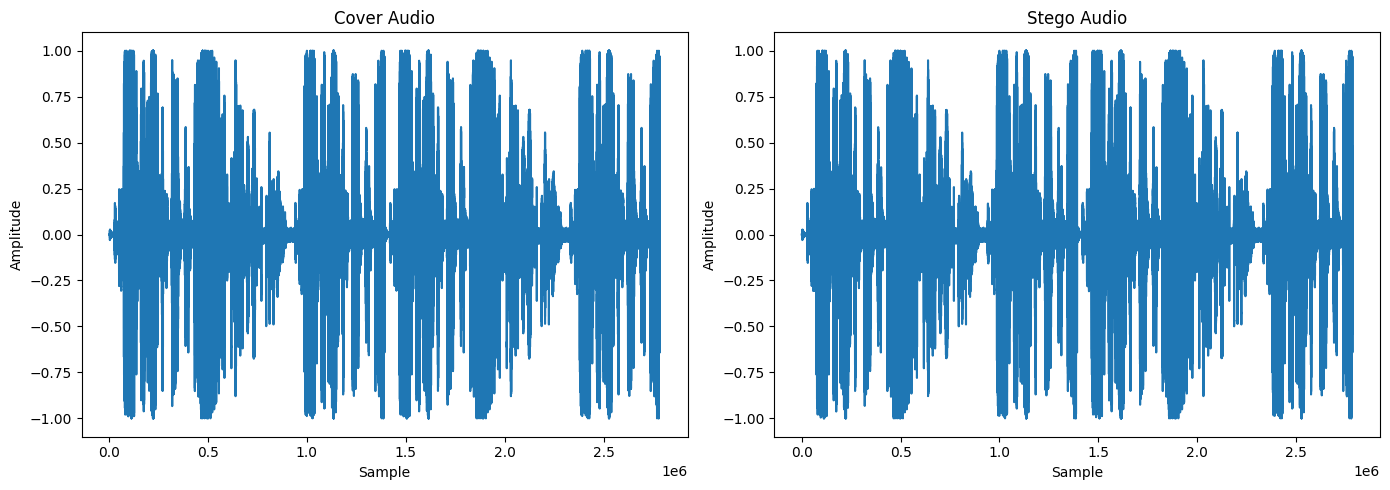

c:\Users\ranaa\anaconda3\envs\Tensorflow\lib\site-packages\matplotlib\axes\_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


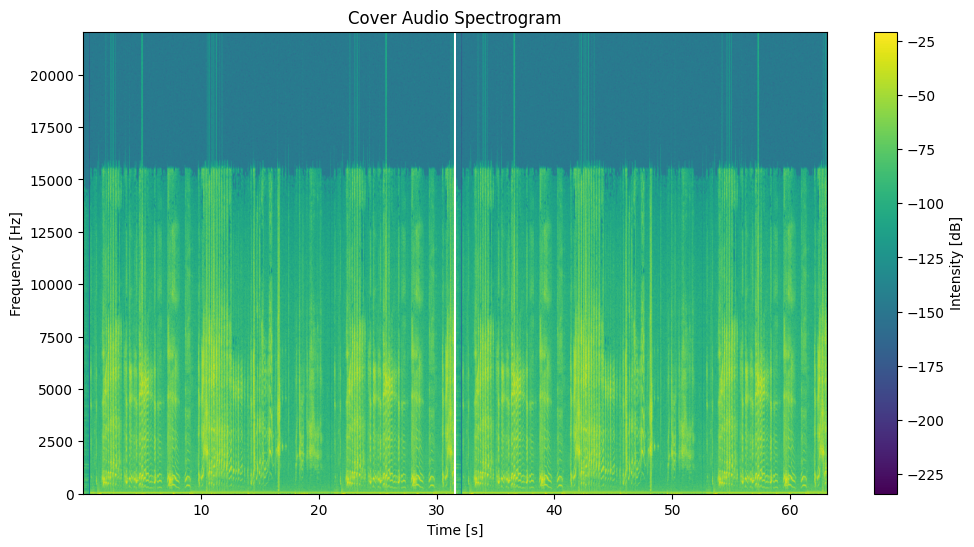

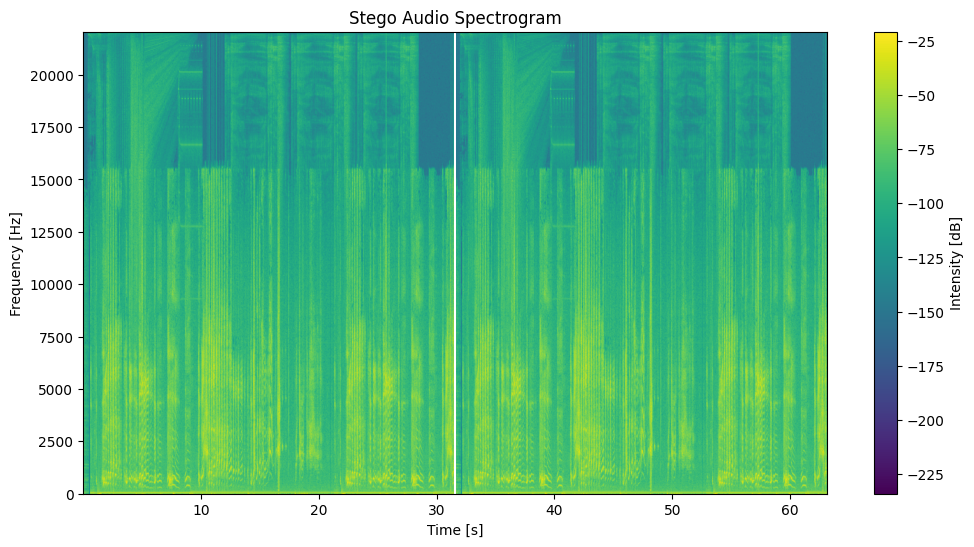

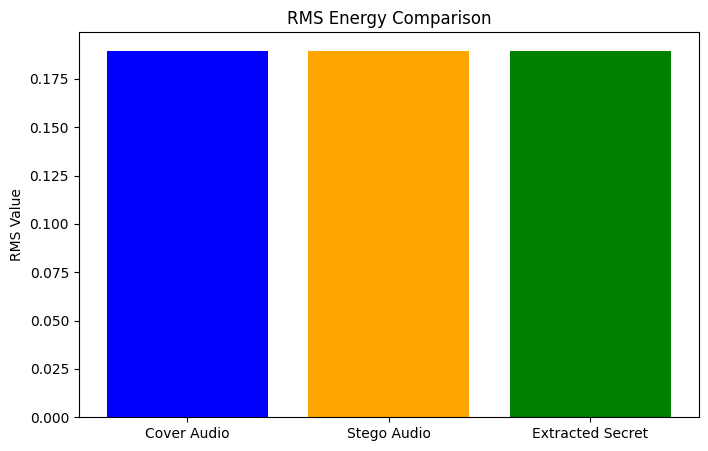

c:\Users\ranaa\anaconda3\envs\Tensorflow\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


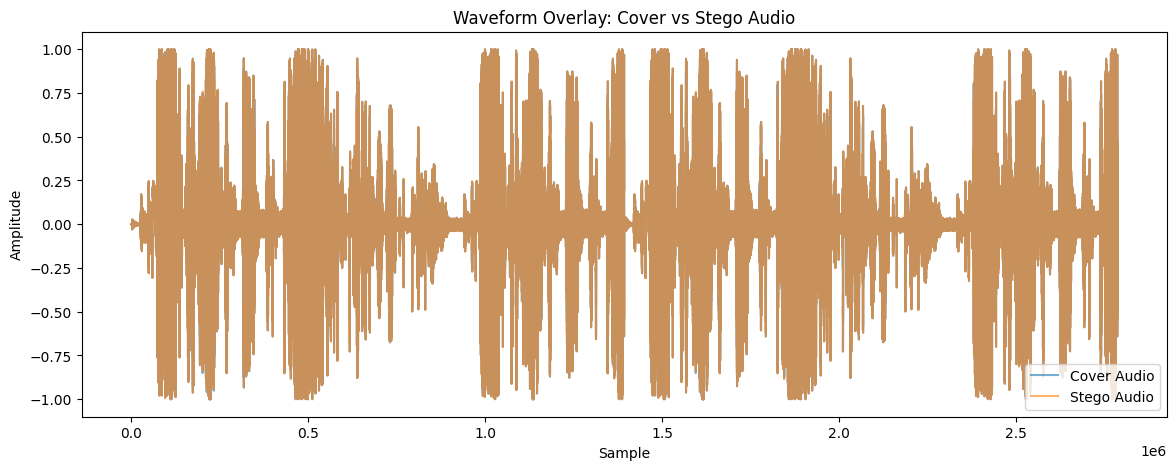

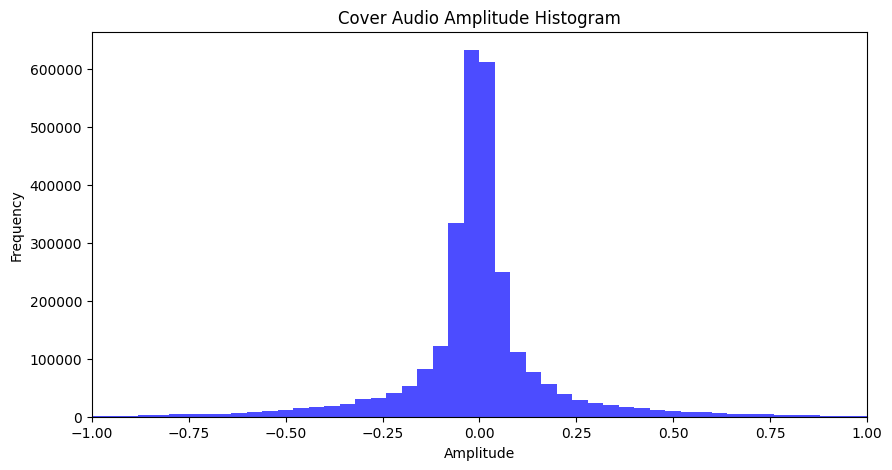

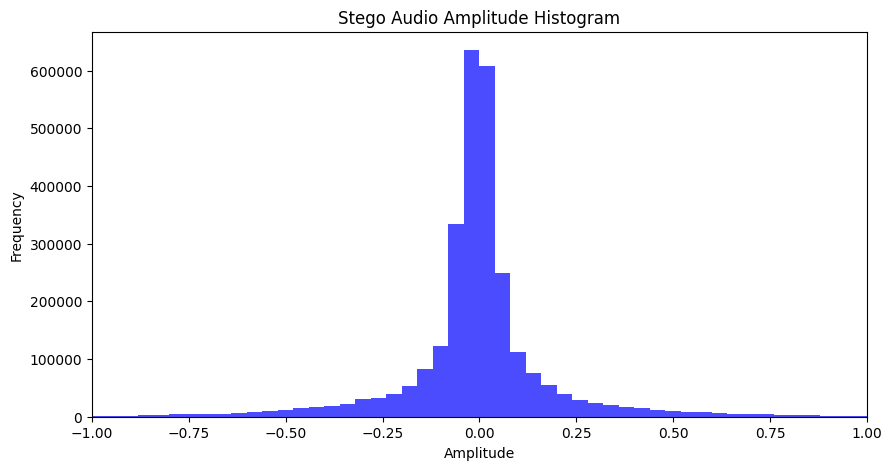

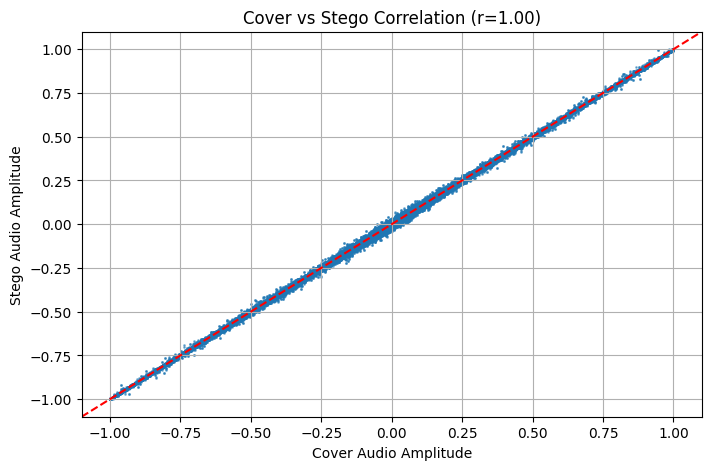

Extracting secret audio from stego audio using DWT...
Saving extracted secret audio to 'extracted_secret.wav'...
Calculating metrics between original and extracted secret audio...
MSE (Original Secret vs Extracted Secret): 0.049879
SNR (Original Secret vs Extracted Secret): -4.96 dB


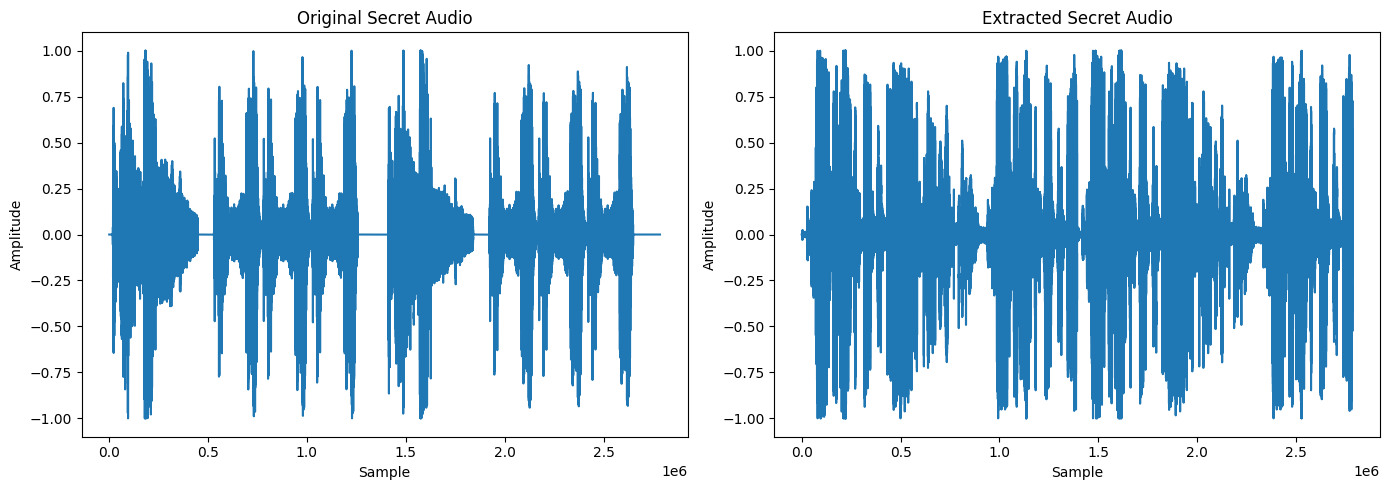

c:\Users\ranaa\anaconda3\envs\Tensorflow\lib\site-packages\matplotlib\axes\_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


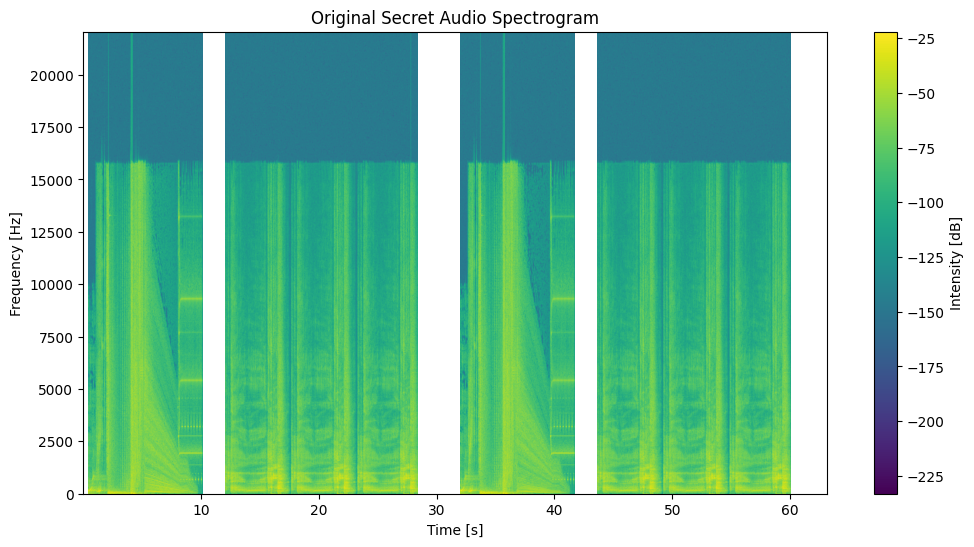

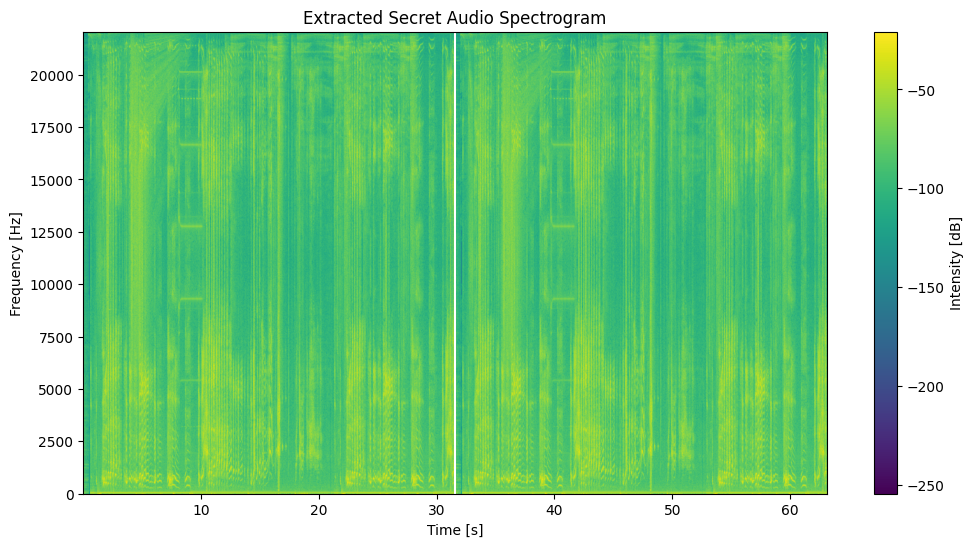

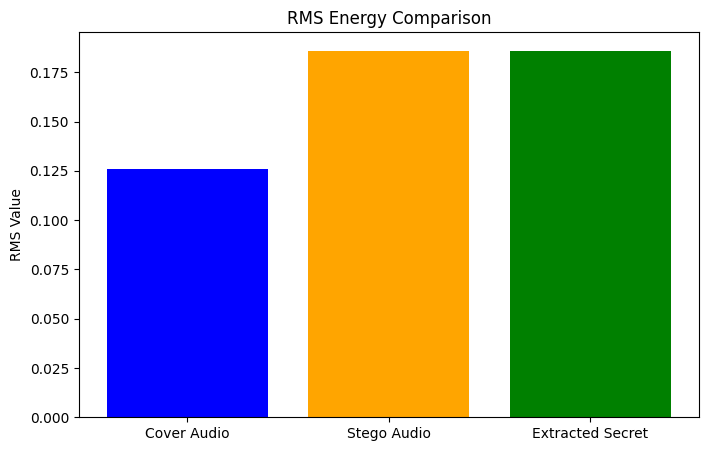

c:\Users\ranaa\anaconda3\envs\Tensorflow\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


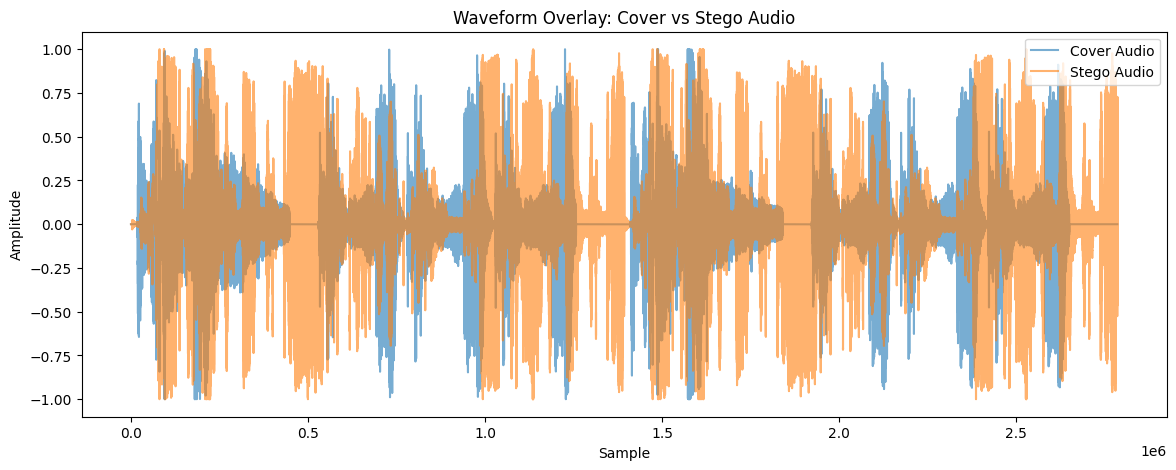

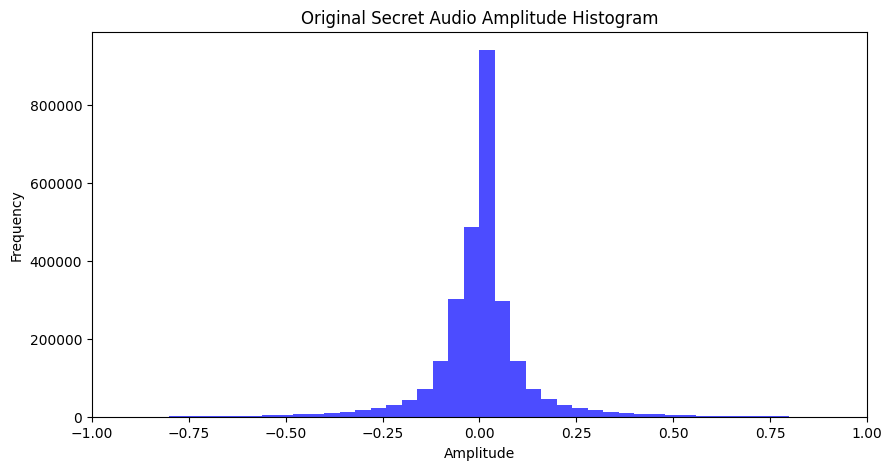

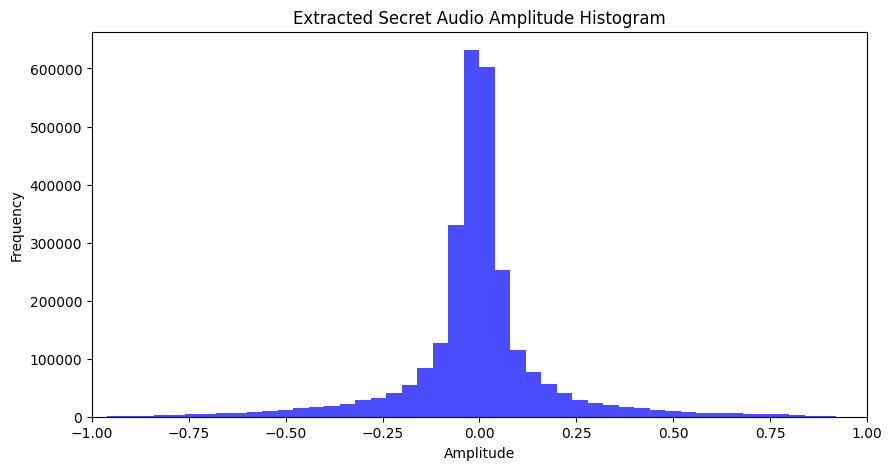

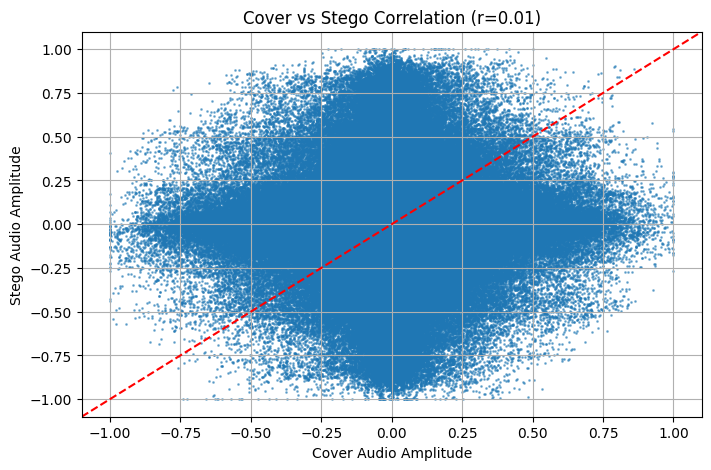

In [7]:
if __name__ == "__main__":
    main()